In [1]:
%pylab inline
data_dir = './data/'
fname_beans = {
    'ggood': data_dir + 'green_good.txt',
    'gspoiled': data_dir + 'green_spoil.txt',
    'gswollen': data_dir + 'green_water.txt',
    'gstale': data_dir + 'green_old.txt',
    'rgood': data_dir + 'red_good.txt',
    'rspoiled': data_dir + 'red_spoil.txt',
    'rswollen': data_dir + 'red_water.txt',
    'rstale': data_dir + 'red_old.txt'
}

Populating the interactive namespace from numpy and matplotlib


- step 1, mbd saliency detection

In [2]:
from saliency_mbd import get_saliency_mbd
from utils import readBeanData, makeRGB
data = readBeanData(fname_beans['rgood'])

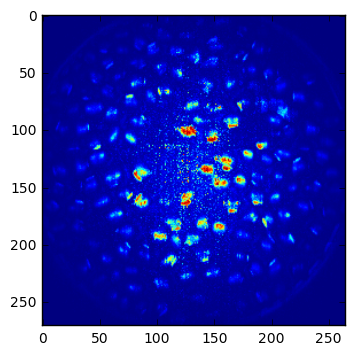

In [3]:
img = makeRGB(data)
mbd = get_saliency_mbd(img)
imshow(mbd)

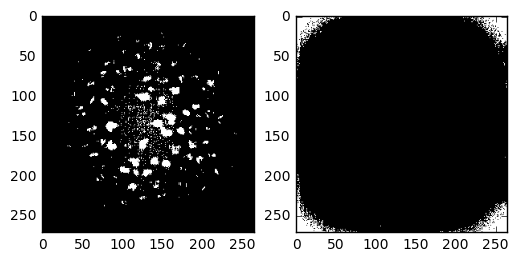

In [4]:
from utils import mark_foreground, mark_background
fg = mark_foreground(mbd, 0.05)
bg = mark_background(mbd, 0.05) #paper里说的是0.05; 而图其实是0.2的图，所以paper的图应该需要更正。
subplot(1,2,1)
imshow(fg, cmap='gray')
subplot(1,2,2)
imshow(bg, cmap='gray')

- 获得foreground和background的spectral

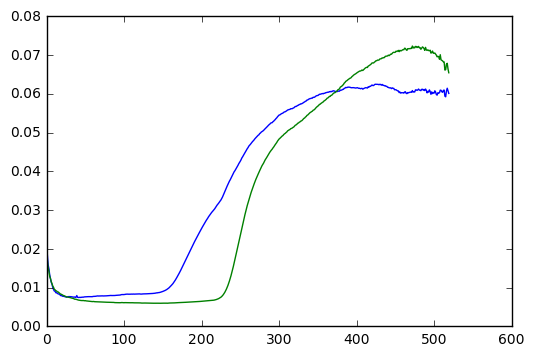

In [5]:
rgood = data
fg_spectral = np.average(rgood[fg,:], axis=0)
fg_spectral = fg_spectral / np.linalg.norm(fg_spectral)

bg_spectral = np.average(rgood[bg,:], axis=0)
bg_spectral = bg_spectral / np.linalg.norm(bg_spectral)

hold
plot(fg_spectral)
plot(bg_spectral)

- step 2: slic superpixel

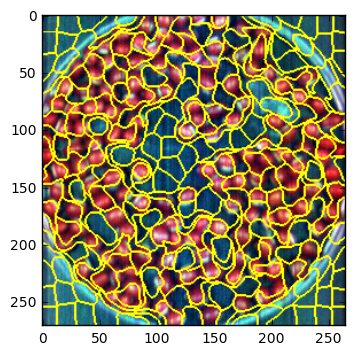

In [6]:
img_rgood = makeRGB(rgood)
from skimage.segmentation import slic, mark_boundaries
segments = slic(img_rgood, n_segments=300, sigma=5)
out=mark_boundaries(img_rgood,segments)
imshow(out)

- mark superpixels to be forground or background

In [7]:
import numpy as np
from skimage.segmentation import mark_boundaries

def testRegion(data, segments, fg, bg, i):
    region = (segments==i)
    regdata = data[region]
    sample = np.average(regdata, axis=0)
    sample = sample 
    dis_fg = np.linalg.norm(sample / np.linalg.norm(sample)-fg)
    dis_bg = np.linalg.norm(sample / np.linalg.norm(sample)-bg)
    if(dis_fg<=dis_bg):
        return True, sample
    else:
        return False, None
    
def get_samples(data, segments, fg, bg):
    maxIter = np.max(segments)
    samples = []
    for i in range(0, maxIter):
        isFg, sample = testRegion(data, segments, fg, bg, i)
        if isFg:
            samples.append(sample)
    return samples

def mark_samples(data, img, segments, fg, bg):
    img_result = mark_boundaries(img, segments, color=(0,0,0))
    result = np.copy(img_result)
    maxIter = np.max(segments)
    for i in range(0, maxIter):
        isFg, sample = testRegion(data, segments, fg, bg, i)
        if isFg:
            result[segments==i]=1
    
    result = mark_boundaries(result, segments, color=(0,0,0))
    return img_result, result


(151, 520)


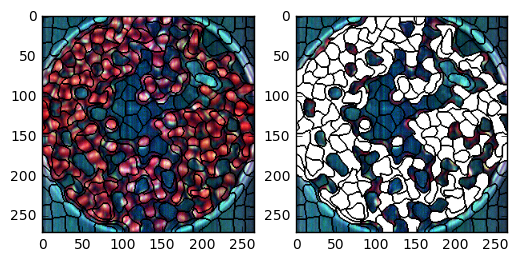

In [8]:
s = get_samples(rgood, segments, fg_spectral, bg_spectral)
print(np.stack(s).shape)

img, mark = mark_samples(rgood, img_rgood, segments, fg_spectral, bg_spectral)

subplot(1,2,1)
imshow(img)
subplot(1,2,2)
imshow(mark)

# 生成所有样本

In [9]:
tmpfile = './output/tmp.jpg'
import pickle
def genSamples(tbl):
    for k,v in tbl.items():
        print(k,v)
        data = readBeanData(v)
        data_img = makeRGB(data)
        data_mbd = get_saliency_mbd(data_img)
        fg = mark_foreground(data_mbd, 0.2) # 论文是0.05, 我也记不清怎么调出来的了，这里看0.2效果好一些
        bg = mark_background(data_mbd, 0.05)
        
        fg_spectral = np.average(data[fg,:], axis=0)
        fg_spectral = fg_spectral / np.linalg.norm(fg_spectral)

        bg_spectral = np.average(data[bg,:], axis=0)
        bg_spectral = bg_spectral / np.linalg.norm(bg_spectral)

        segments = slic(data_img, n_segments=300, sigma=5)
        samples = get_samples(data, segments, fg_spectral, bg_spectral)
        print(len(samples))
        img, mark = mark_samples(data, data_img, segments, fg_spectral, bg_spectral)
        figure()
        subplot(1,2,1)
        imshow(img)
        subplot(1,2,2)
        imshow(mark)
        with open('./output/'+k+'.pkl', 'wb') as f:
            pickle.dump(samples, f)

ggood ./data/green_good.txt
140
gspoiled ./data/green_spoil.txt
146
rgood ./data/red_good.txt
170
rspoiled ./data/red_spoil.txt
156
rswollen ./data/red_water.txt
110
rstale ./data/red_old.txt
119
gswollen ./data/green_water.txt
104
gstale ./data/green_old.txt
129


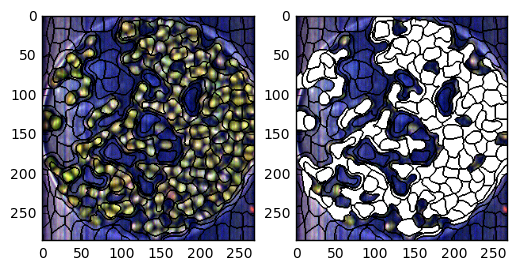

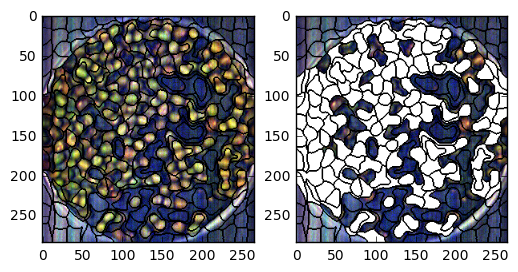

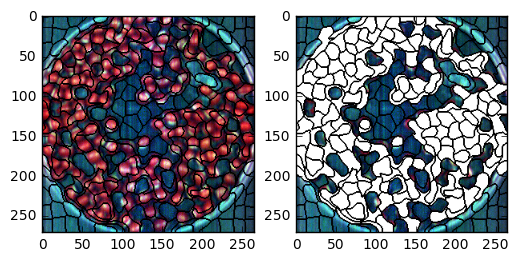

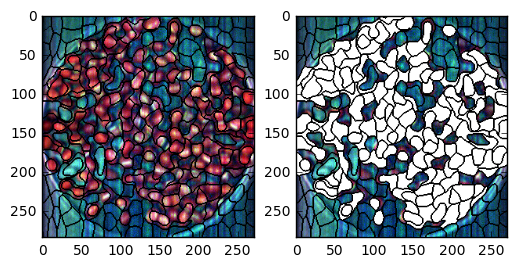

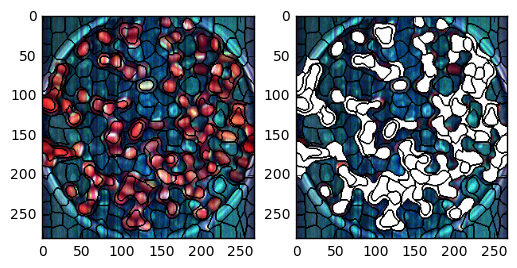

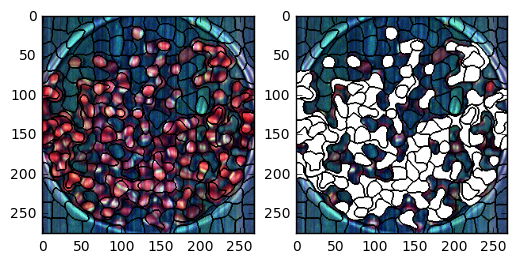

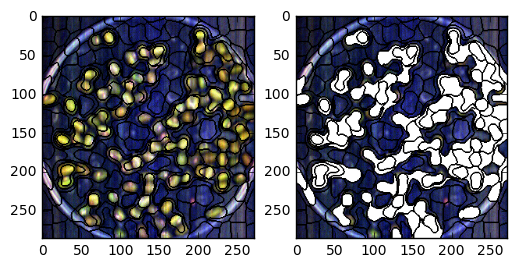

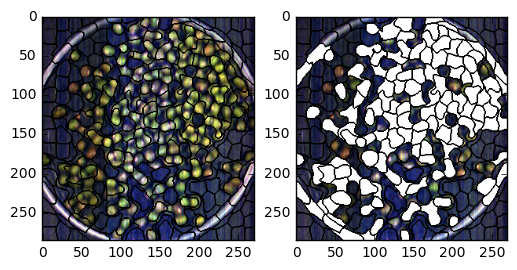

In [10]:
genSamples(fname_beans)